In [1]:
import torch
import numpy as np
from datagen import ImageEntity, ImageAttackPipeline, UpscaleImageTransform, create_entities
from datasets import load_dataset, create_dataloader, entity_to_dataset
from modules import NetModule, train, test

/home/andmholm/Backdoor/backdoor_env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# loading our desired vision dataset
traindata, testdata = load_dataset('mnist')

Converting tensors to numpy arrays


In [3]:
# turning data & labels into entities for poisoning
data, labels = traindata.data, traindata.targets
entities = create_entities(data, labels, ImageEntity)

# getting mappings for encodings to name label
mappings = {v: k for k,v in traindata.class_to_idx.items()} 

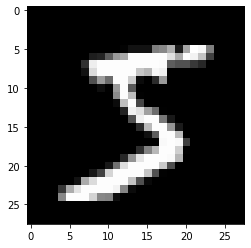

Label: 5 - five


In [4]:
# viewing our entities
ex_entity = entities[0]
ex_entity.show()
print(f'Label: {mappings[ex_entity.get_label()]}')


In [5]:
# poisoning entities
random_state = np.random.RandomState(42)
targets = {i: i + 1 if i < 9 else 0 for i in range(len(mappings))}
transforms = [UpscaleImageTransform(scale=10)]
patch_size = (40, 40)
pipeline = ImageAttackPipeline()
clean, poisoned = pipeline.process(entities, transforms, patch_size=patch_size, targets=targets, random_state_obj=random_state)

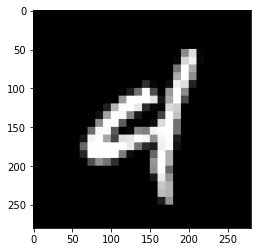

Original Label: 4 - four


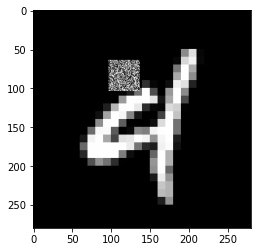

Poisoned Label: 5 - five


In [6]:
injected = pipeline.injections
sample_injected = injected[0]
clean[sample_injected].show()
print(f'Original Label: {mappings[clean[sample_injected].get_label()]}')
poisoned[sample_injected].show()
print(f'Poisoned Label: {mappings[poisoned[sample_injected].get_label()]}')


In [7]:
cleanset = entity_to_dataset(clean)
poisonset = entity_to_dataset(poisoned)

Clean dataset size: 60000
Poisoned dataset size: 60000
Injected dataset size: 12000
Clean Input shape: torch.Size([280, 280, 1])
Clean Output shape: torch.Size([])
Posioned Input shape: torch.Size([280, 280, 1])
Posioned Output shape: torch.Size([])


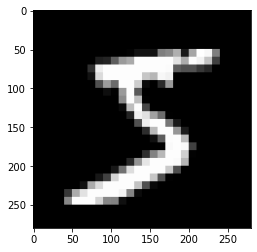

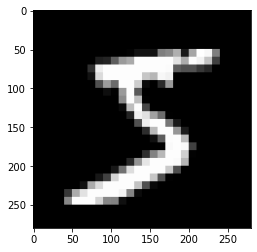

In [30]:
import matplotlib.pyplot as plt
print(f'Clean dataset size: {len(cleanset)}')
print(f'Poisoned dataset size: {len(poisonset)}')
print(f'Injected dataset size: {len(injected)}')
print(f'Clean Input shape: {cleanset[0][0].size()}')
print(f'Clean Output shape: {cleanset[0][1].size()}')
print(f'Posioned Input shape: {poisonset[0][0].size()}')
print(f'Posioned Output shape: {poisonset[0][1].size()}')

plt.imshow(cleanset[0][0].numpy().astype(np.uint8), cmap='gray')
plt.show()
plt.imshow(poisonset[0][0].numpy().astype(np.uint8), cmap='gray')
plt.show()

In [33]:
cleantrainloader = create_dataloader(cleanset, batch_size=32, n_workers=2, shuffle=True)
poisontrainloader = create_dataloader(poisonset, batch_size=32, n_workers=2, shuffle=True)

In [34]:
cleaniter = iter(cleantrainloader)
poisoniter = iter(poisontrainloader)
clean_inputs, clean_labels = cleaniter.next()
posioned_inputs, poisoned_labels = poisoniter.next()
print(f'Clean Input shape: {clean_inputs.size()} | CLean Labels shape: {clean_labels.size()}')
print(f'Clean Input shape: {posioned_inputs.size()} | CLean Labels shape: {poisoned_labels.size()}')

Clean Input shape: torch.Size([32, 280, 280, 1]) | CLean Labels shape: torch.Size([32])
